# Resolution Refinement for Enlarged Scale Images Using GANs

In [1]:
#starting to build GANs network
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
images=np.load('data.npy')
resized8=np.load('array8.npy')
%matplotlib inline

In [2]:
print("Training set size:\t",len(images))

Training set size:	 50000


In [3]:
images=images[:200]
resized8=resized8[:200]
print(len(images))

200


In [4]:
import tensorflow.contrib.layers as lays
def generator(input,reuse=None):
    with tf.variable_scope('gen',reuse=reuse):
        net = lays.conv2d_transpose(input,16, [5, 5], stride=2, padding='SAME')
        net = lays.conv2d_transpose(net,32, [5, 5], stride=2, padding='SAME')
        net = lays.conv2d_transpose(net, 3, [5, 5], stride=1, padding='SAME', activation_fn=tf.nn.tanh)
        return net

In [5]:
def discriminator(input,reuse=True):
    with tf.variable_scope('dis',reuse=reuse):
        net = lays.conv2d(input, 32, [5, 5], stride=2, padding='SAME',activation_fn=tf.nn.relu) #16 x16 x 32
        net = lays.conv2d(net, 16, [5, 5], stride=2, padding='SAME',activation_fn=tf.nn.relu) # 8 x 8 x 16
        net = lays.conv2d(net, 8, [5, 5], stride=4, padding='SAME',activation_fn=tf.nn.relu) #--> 2 x 2 x 8
        dim = int(np.prod(net.get_shape()[1:]))
        fc1 = tf.reshape(net, shape=[-1, dim], name='fc1')
        w2 = tf.get_variable('w2', shape=[fc1.shape[-1], 1], dtype=tf.float32,initializer=tf.truncated_normal_initializer(stddev=0.02))
        b2 = tf.get_variable('b2', shape=[1], dtype=tf.float32,initializer=tf.constant_initializer(0.0))
        logits = tf.add(tf.matmul(fc1, w2), b2, name='logits')
        Dis_out = tf.nn.sigmoid(logits)
        return logits

In [6]:
tf.reset_default_graph()
real_images=tf.placeholder(tf.float32, (None,32, 32, 3))
inputs_= tf.placeholder(tf.float32, (None,8, 8, 3))
G=generator(inputs_)
D_real=discriminator(real_images,reuse=None)
D_fake=discriminator(G,reuse=True)

Instructions for updating:
Colocations handled automatically by placer.


In [7]:
def loss_func(logits_in,labels_in):
    return tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=logits_in,labels=labels_in))
D_loss=loss_func(D_real,tf.ones_like(D_real)) #Smoothing for generalization
D_fake_loss=loss_func(D_fake,tf.zeros_like(D_real))
#D_loss=D_loss+D_fake_loss
G_loss= loss_func(D_fake,tf.ones_like(D_fake))

#D_loss=tf.reduce_mean(D_fake)-tf.reduce_mean(D_real)
#G_loss=-tf.reduce_mean(D_fake)
S_loss = tf.reduce_mean((G-real_images)**2)

==>>*Due to PC restriction for Training large number of the data,and it takes many times for training, here I run the training iteration only for 200 sample images, and 100 epochs*

In [8]:
lr=0.0005 #0.0002

#Do this when multiple networks interact with each other
tvars=tf.trainable_variables()  #returns all variables created(the two variable scopes) and makes trainable true
d_vars=[var for var in tvars if 'dis' in var.name]
g_vars=[var for var in tvars if 'gen' in var.name]
GENLOSS=G_loss+S_loss
D_trainer=tf.train.AdamOptimizer(lr).minimize(D_loss,var_list=d_vars)
G_trainer=tf.train.AdamOptimizer(lr).minimize(GENLOSS,var_list=g_vars) #0.001*g_loss+d_loss
#G_trainer=tf.train.AdamOptimizer(lr).minimize((0.001*G_loss+D_loss),var_list=g_vars)
batch_size=20
epochs=100
h=len(images)
init=tf.global_variables_initializer()

In [12]:
samples=[] #generator examples
Daverageloss=[]
Gaverageloss=[]
with tf.Session() as sess:
    sess.run(init)
    for epoch in range(epochs):
        num_batches=h//batch_size
        print('epoch ',epoch)
        DLOSS=[]
        GLOSS=[]
        
        for i in range(num_batches):
            #m=i*batch_size
            batch_images=images[i*batch_size : (i+1)*batch_size].reshape(batch_size,32,32,3)
            batch_z=resized8[i*batch_size : (i+1)*batch_size].reshape(batch_size,8,8,3)
            Go=sess.run(generator(inputs_,reuse=True),feed_dict={inputs_:batch_z})
           # _=sess.run(D_trainer,feed_dict={real_images:batch_images,inputs_:batch_z})
           # _=sess.run(G_trainer,feed_dict={inputs_:batch_z})
            Dloss, _ = sess.run([D_loss, D_trainer], feed_dict={real_images:batch_images,G:Go})
            Genloss, _ = sess.run([GENLOSS, G_trainer], feed_dict={inputs_:batch_z,real_images:batch_images})
            #Genloss, _ = sess.run([G_loss, G_trainer], feed_dict={inputs_:batch_z,real_images:batch_images})
            DLOSS.append(Dloss)
            GLOSS.append(Genloss)
            if epoch==epochs-1:
                samples.append(Go)
            #Genloss, _ = sess.run([g_loss, train_Gen], feed_dict={Sr:G,Hr:batch_images})
            print('epoch {} batch number {}   discrim batch loss: {} Gen batch loss: {}'.format(epoch,i,Dloss,Genloss))
        MeanDloss=np.mean(DLOSS)
        MeanGlos=np.mean(GLOSS)
        Daverageloss.append(np.mean(DLOSS))
        Gaverageloss.append(MeanGlos)
        print(' Average discrim loss: {} Average Gen loss: {} '.format(MeanDloss,MeanGlos))
       
     

epoch  0
epoch 0 batch number 0   discrim batch loss: 0.6935243606567383 Gen batch loss: 0.9285053014755249
epoch 0 batch number 1   discrim batch loss: 0.6904551386833191 Gen batch loss: 0.9189075827598572
epoch 0 batch number 2   discrim batch loss: 0.6872901320457458 Gen batch loss: 0.931087851524353
epoch 0 batch number 3   discrim batch loss: 0.6849616765975952 Gen batch loss: 0.8957095146179199
epoch 0 batch number 4   discrim batch loss: 0.6816189289093018 Gen batch loss: 0.8579193353652954
epoch 0 batch number 5   discrim batch loss: 0.6759861707687378 Gen batch loss: 0.9060606956481934
epoch 0 batch number 6   discrim batch loss: 0.669355034828186 Gen batch loss: 0.8761720061302185
epoch 0 batch number 7   discrim batch loss: 0.6637123227119446 Gen batch loss: 0.8297483325004578
epoch 0 batch number 8   discrim batch loss: 0.66053706407547 Gen batch loss: 0.7953252196311951
epoch 0 batch number 9   discrim batch loss: 0.6452017426490784 Gen batch loss: 0.7827434539794922
 Aver

epoch 7 batch number 5   discrim batch loss: 1.1217846349609317e-06 Gen batch loss: 0.048356056213378906
epoch 7 batch number 6   discrim batch loss: 0.00011779160558944568 Gen batch loss: 0.041098132729530334
epoch 7 batch number 7   discrim batch loss: 2.042900632659439e-06 Gen batch loss: 0.03497916832566261
epoch 7 batch number 8   discrim batch loss: 7.900853961473331e-05 Gen batch loss: 0.0395406074821949
epoch 7 batch number 9   discrim batch loss: 1.6945266906986944e-05 Gen batch loss: 0.03457703813910484
 Average discrim loss: 2.6685785996960476e-05 Average Gen loss: 0.04069126024842262 
epoch  8
epoch 8 batch number 0   discrim batch loss: 1.8287941202288494e-05 Gen batch loss: 0.04163272678852081
epoch 8 batch number 1   discrim batch loss: 6.365485660353443e-06 Gen batch loss: 0.03813859820365906
epoch 8 batch number 2   discrim batch loss: 3.97475514546386e-06 Gen batch loss: 0.03922140225768089
epoch 8 batch number 3   discrim batch loss: 3.1026097531139385e-06 Gen batch 

epoch 14 batch number 7   discrim batch loss: 1.5372928601209424e-06 Gen batch loss: 0.02110358141362667
epoch 14 batch number 8   discrim batch loss: 6.643000233452767e-05 Gen batch loss: 0.024281485006213188
epoch 14 batch number 9   discrim batch loss: 1.388900818710681e-05 Gen batch loss: 0.021182727068662643
 Average discrim loss: 2.184106233471539e-05 Average Gen loss: 0.025527900084853172 
epoch  15
epoch 15 batch number 0   discrim batch loss: 1.505188993178308e-05 Gen batch loss: 0.026989948004484177
epoch 15 batch number 1   discrim batch loss: 5.084971235191915e-06 Gen batch loss: 0.02598648890852928
epoch 15 batch number 2   discrim batch loss: 3.179752411597292e-06 Gen batch loss: 0.025842586532235146
epoch 15 batch number 3   discrim batch loss: 2.484050583007047e-06 Gen batch loss: 0.025202862918376923
epoch 15 batch number 4   discrim batch loss: 9.66892548603937e-06 Gen batch loss: 0.023772776126861572
epoch 15 batch number 5   discrim batch loss: 7.7948982379894e-07 G

epoch 21 batch number 9   discrim batch loss: 1.0695743185351603e-05 Gen batch loss: 0.015455337241292
 Average discrim loss: 1.8180111510446295e-05 Average Gen loss: 0.01883198879659176 
epoch  22
epoch 22 batch number 0   discrim batch loss: 1.1235895726713352e-05 Gen batch loss: 0.0209702979773283
epoch 22 batch number 1   discrim batch loss: 3.4897707337222528e-06 Gen batch loss: 0.020373448729515076
epoch 22 batch number 2   discrim batch loss: 2.10265943678678e-06 Gen batch loss: 0.01951815001666546
epoch 22 batch number 3   discrim batch loss: 1.5708371847722447e-06 Gen batch loss: 0.019765326753258705
epoch 22 batch number 4   discrim batch loss: 6.562507223861758e-06 Gen batch loss: 0.01897544227540493
epoch 22 batch number 5   discrim batch loss: 4.5184839336798177e-07 Gen batch loss: 0.02084656059741974
epoch 22 batch number 6   discrim batch loss: 7.361055031651631e-05 Gen batch loss: 0.01647185906767845
epoch 22 batch number 7   discrim batch loss: 8.353499652002938e-07 Ge

epoch 29 batch number 0   discrim batch loss: 7.459978519364086e-07 Gen batch loss: 0.019180171191692352
epoch 29 batch number 1   discrim batch loss: 1.2213449451792258e-07 Gen batch loss: 0.01887364313006401
epoch 29 batch number 2   discrim batch loss: 6.849876399428467e-08 Gen batch loss: 0.017900729551911354
epoch 29 batch number 3   discrim batch loss: 4.512263629408153e-08 Gen batch loss: 0.01834564283490181
epoch 29 batch number 4   discrim batch loss: 3.847737275464169e-07 Gen batch loss: 0.0176844485104084
epoch 29 batch number 5   discrim batch loss: 9.816554680242007e-09 Gen batch loss: 0.018880942836403847
epoch 29 batch number 6   discrim batch loss: 1.0812448635988403e-05 Gen batch loss: 0.014939216896891594
epoch 29 batch number 7   discrim batch loss: 2.25498411055014e-08 Gen batch loss: 0.013583691790699959
epoch 29 batch number 8   discrim batch loss: 5.192325716052437e-06 Gen batch loss: 0.016238678246736526
epoch 29 batch number 9   discrim batch loss: 5.4969802931

epoch 36 batch number 2   discrim batch loss: 1.2217862277452696e-08 Gen batch loss: 0.016753077507019043
epoch 36 batch number 3   discrim batch loss: 7.616132613463833e-09 Gen batch loss: 0.017486069351434708
epoch 36 batch number 4   discrim batch loss: 9.44848252970587e-08 Gen batch loss: 0.016654416918754578
epoch 36 batch number 5   discrim batch loss: 1.443177466420309e-09 Gen batch loss: 0.01752890832722187
epoch 36 batch number 6   discrim batch loss: 4.170911324763438e-06 Gen batch loss: 0.014035740867257118
epoch 36 batch number 7   discrim batch loss: 3.924503388930134e-09 Gen batch loss: 0.012784259393811226
epoch 36 batch number 8   discrim batch loss: 1.865422973423847e-06 Gen batch loss: 0.01525676529854536
epoch 36 batch number 9   discrim batch loss: 1.465677144096844e-07 Gen batch loss: 0.012717791832983494
 Average discrim loss: 6.508623187073681e-07 Average Gen loss: 0.01586940512061119 
epoch  37
epoch 37 batch number 0   discrim batch loss: 1.6075831865691725e-07

epoch 43 batch number 4   discrim batch loss: 4.1447460574772776e-08 Gen batch loss: 0.01528038177639246
epoch 43 batch number 5   discrim batch loss: 4.530975039607199e-10 Gen batch loss: 0.016027502715587616
epoch 43 batch number 6   discrim batch loss: 2.362729446758749e-06 Gen batch loss: 0.013126610778272152
epoch 43 batch number 7   discrim batch loss: 1.3826764178048734e-09 Gen batch loss: 0.011830488219857216
epoch 43 batch number 8   discrim batch loss: 1.010690084513044e-06 Gen batch loss: 0.014209603890776634
epoch 43 batch number 9   discrim batch loss: 6.544027542076947e-08 Gen batch loss: 0.011619528755545616
 Average discrim loss: 3.5799703823613527e-07 Average Gen loss: 0.014628341421484947 
epoch  44
epoch 44 batch number 0   discrim batch loss: 7.526803358359757e-08 Gen batch loss: 0.01594594679772854
epoch 44 batch number 1   discrim batch loss: 7.181832906155705e-09 Gen batch loss: 0.01592913642525673
epoch 44 batch number 2   discrim batch loss: 4.001214026772004e-

epoch 50 batch number 6   discrim batch loss: 1.5596109506077482e-06 Gen batch loss: 0.012376265600323677
epoch 50 batch number 7   discrim batch loss: 6.451996714673669e-10 Gen batch loss: 0.011006688699126244
epoch 50 batch number 8   discrim batch loss: 6.45435363821889e-07 Gen batch loss: 0.013370645232498646
epoch 50 batch number 9   discrim batch loss: 3.636625578451458e-08 Gen batch loss: 0.010810266248881817
 Average discrim loss: 2.3187473630059685e-07 Average Gen loss: 0.013577558100223541 
epoch  51
epoch 51 batch number 0   discrim batch loss: 4.3152766693310696e-08 Gen batch loss: 0.014700312167406082
epoch 51 batch number 1   discrim batch loss: 3.591783537260085e-09 Gen batch loss: 0.014584753662347794
epoch 51 batch number 2   discrim batch loss: 1.99397898192899e-09 Gen batch loss: 0.013965652324259281
epoch 51 batch number 3   discrim batch loss: 1.1521976706063697e-09 Gen batch loss: 0.015571079216897488
epoch 51 batch number 4   discrim batch loss: 2.115701214222554

epoch 57 batch number 8   discrim batch loss: 4.5146734350964834e-07 Gen batch loss: 0.012857196852564812
epoch 57 batch number 9   discrim batch loss: 2.279866251342355e-08 Gen batch loss: 0.010372134856879711
 Average discrim loss: 1.6426120907908626e-07 Average Gen loss: 0.012980667874217033 
epoch  58
epoch 58 batch number 0   discrim batch loss: 2.7691260839901588e-08 Gen batch loss: 0.014077235013246536
epoch 58 batch number 1   discrim batch loss: 2.0654853383206273e-09 Gen batch loss: 0.013809029012918472
epoch 58 batch number 2   discrim batch loss: 1.1432566004998534e-09 Gen batch loss: 0.013315831311047077
epoch 58 batch number 3   discrim batch loss: 6.439860866791491e-10 Gen batch loss: 0.015030535869300365
epoch 58 batch number 4   discrim batch loss: 1.3331796999693779e-08 Gen batch loss: 0.013301920145750046
epoch 58 batch number 5   discrim batch loss: 9.263681488569375e-11 Gen batch loss: 0.014208078384399414
epoch 58 batch number 6   discrim batch loss: 1.07375956304

epoch 65 batch number 0   discrim batch loss: 1.910659896964262e-08 Gen batch loss: 0.013641143217682838
epoch 65 batch number 1   discrim batch loss: 1.2997826148719582e-09 Gen batch loss: 0.013254152610898018
epoch 65 batch number 2   discrim batch loss: 7.176262362129648e-10 Gen batch loss: 0.012866921722888947
epoch 65 batch number 3   discrim batch loss: 3.9546338426177385e-10 Gen batch loss: 0.014616357162594795
epoch 65 batch number 4   discrim batch loss: 9.050987515024644e-09 Gen batch loss: 0.012897194363176823
epoch 65 batch number 5   discrim batch loss: 5.396421157155551e-11 Gen batch loss: 0.013789155520498753
epoch 65 batch number 6   discrim batch loss: 8.193019311875105e-07 Gen batch loss: 0.011453610844910145
epoch 65 batch number 7   discrim batch loss: 1.981671077233571e-10 Gen batch loss: 0.010163689032196999
epoch 65 batch number 8   discrim batch loss: 3.220165467610059e-07 Gen batch loss: 0.012419340200722218
epoch 65 batch number 9   discrim batch loss: 1.46745

epoch 72 batch number 2   discrim batch loss: 4.801296027423518e-10 Gen batch loss: 0.012485642917454243
epoch 72 batch number 3   discrim batch loss: 2.5954924320892303e-10 Gen batch loss: 0.014261184260249138
epoch 72 batch number 4   discrim batch loss: 6.47628173311432e-09 Gen batch loss: 0.012514714151620865
epoch 72 batch number 5   discrim batch loss: 3.150411181929158e-11 Gen batch loss: 0.013372785411775112
epoch 72 batch number 6   discrim batch loss: 6.094334139561397e-07 Gen batch loss: 0.011107424274086952
epoch 72 batch number 7   discrim batch loss: 1.29072558197052e-10 Gen batch loss: 0.00990044791251421
epoch 72 batch number 8   discrim batch loss: 2.4404116061305103e-07 Gen batch loss: 0.012088573537766933
epoch 72 batch number 9   discrim batch loss: 9.935980038733305e-09 Gen batch loss: 0.009709129109978676
 Average discrim loss: 8.855304400867681e-08 Average Gen loss: 0.012140803970396519 
epoch  73
epoch 73 batch number 0   discrim batch loss: 1.3304903845323679e-

epoch 79 batch number 4   discrim batch loss: 3.756733590876138e-09 Gen batch loss: 0.012123385444283485
epoch 79 batch number 5   discrim batch loss: 1.612432062869651e-11 Gen batch loss: 0.0129832923412323
epoch 79 batch number 6   discrim batch loss: 3.8653894307572045e-07 Gen batch loss: 0.010806265287101269
epoch 79 batch number 7   discrim batch loss: 8.667334905343438e-11 Gen batch loss: 0.009662602096796036
epoch 79 batch number 8   discrim batch loss: 1.5273080578026565e-07 Gen batch loss: 0.011786711402237415
epoch 79 batch number 9   discrim batch loss: 6.228331184132685e-09 Gen batch loss: 0.00940137729048729
 Average discrim loss: 5.611212117173636e-08 Average Gen loss: 0.011795764788985252 
epoch  80
epoch 80 batch number 0   discrim batch loss: 1.0390147409111705e-08 Gen batch loss: 0.012768574990332127
epoch 80 batch number 1   discrim batch loss: 4.953895071935221e-10 Gen batch loss: 0.01220460794866085
epoch 80 batch number 2   discrim batch loss: 3.230340994697656e-1

epoch 86 batch number 6   discrim batch loss: 1.873284958264776e-07 Gen batch loss: 0.01053223479539156
epoch 86 batch number 7   discrim batch loss: 5.2791764015847065e-11 Gen batch loss: 0.009431663900613785
epoch 86 batch number 8   discrim batch loss: 1.0307461195679934e-07 Gen batch loss: 0.011493457481265068
epoch 86 batch number 9   discrim batch loss: 4.399427044887716e-09 Gen batch loss: 0.009103361517190933
 Average discrim loss: 3.066055143108315e-08 Average Gen loss: 0.011457027867436409 
epoch  87
epoch 87 batch number 0   discrim batch loss: 8.727825573373593e-09 Gen batch loss: 0.012375717051327229
epoch 87 batch number 1   discrim batch loss: 3.057127884176225e-10 Gen batch loss: 0.011727342382073402
epoch 87 batch number 2   discrim batch loss: 2.510997521021352e-10 Gen batch loss: 0.011783763766288757
epoch 87 batch number 3   discrim batch loss: 1.1914262632028993e-10 Gen batch loss: 0.01360275037586689
epoch 87 batch number 4   discrim batch loss: 1.9216430668933526

epoch 93 batch number 8   discrim batch loss: 7.827911474578286e-08 Gen batch loss: 0.011209867894649506
epoch 93 batch number 9   discrim batch loss: 2.4793265218647775e-09 Gen batch loss: 0.008820868097245693
 Average discrim loss: 1.7868533319642665e-08 Average Gen loss: 0.011111092753708363 
epoch  94
epoch 94 batch number 0   discrim batch loss: 7.824984216142639e-09 Gen batch loss: 0.011976810172200203
epoch 94 batch number 1   discrim batch loss: 1.9076307200549536e-10 Gen batch loss: 0.011199182830750942
epoch 94 batch number 2   discrim batch loss: 1.775372349133164e-10 Gen batch loss: 0.011455565690994263
epoch 94 batch number 3   discrim batch loss: 8.544193824677748e-11 Gen batch loss: 0.013295050710439682
epoch 94 batch number 4   discrim batch loss: 9.878439177768428e-10 Gen batch loss: 0.01114887185394764
epoch 94 batch number 5   discrim batch loss: 5.527854649717279e-12 Gen batch loss: 0.012188605032861233
epoch 94 batch number 6   discrim batch loss: 8.033715914734785

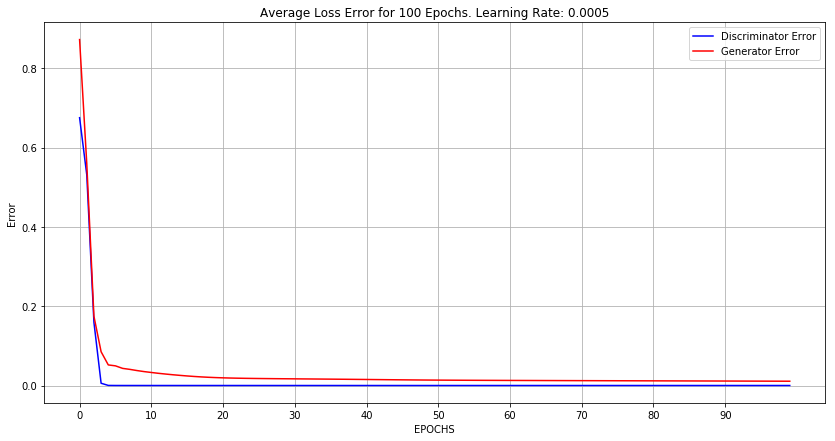

In [28]:
t=np.arange(epochs)
plt.figure(figsize=(14,7))
plt.title('Average Loss Error for {} Epochs. Learning Rate: {}'.format(epochs,lr))
plt.plot(t,Daverageloss,color='b',label='Discriminator Error')
plt.plot(t,Gaverageloss,color='r',label='Generator Error')
plt.xticks(np.arange(0,epochs,10))
plt.xlabel('EPOCHS')
plt.ylabel('Error')
plt.grid(True)
plt.legend()

## Predicted Images (32 x 32) From Low Scale Images(8 X 8)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


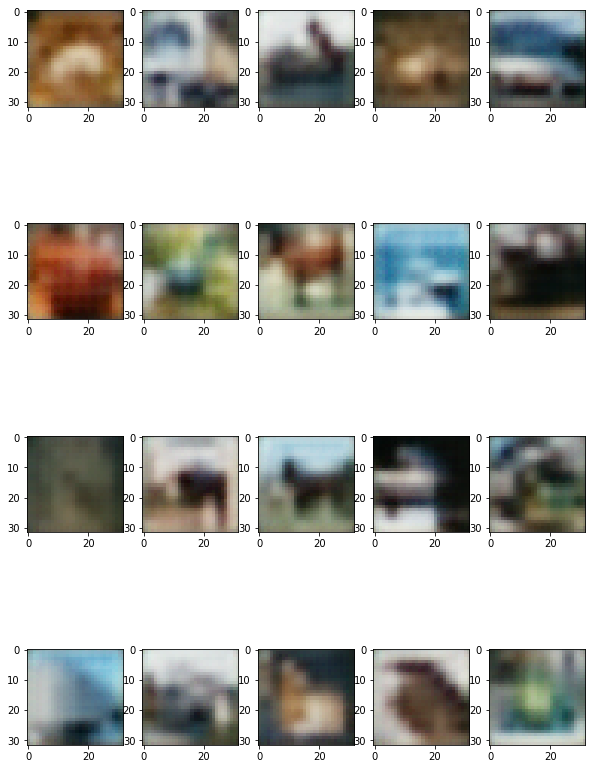

In [23]:
H=np.reshape(samples,(h,32,32,3))
fig=plt.figure(figsize=(10, 15))
columns = 5
rows = 4
for i in range(0, columns*rows ):
    #img = np.random.randint(10, size=(h,w))
    img=H[i]
    fig.add_subplot(rows, columns, (i+1))
    plt.imshow(img)
plt.show()

In [24]:
np.shape(samples)

(10, 20, 32, 32, 3)

## **Original Low Scale Images(8x8) From CIFAR10 dataset**

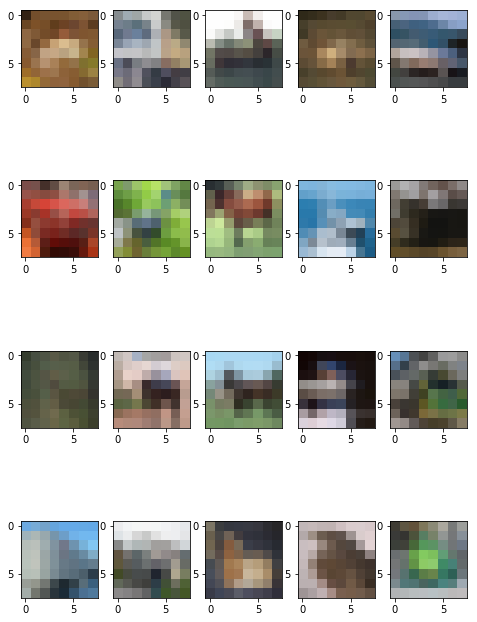

In [25]:
columns = 5
rows = 4
fig=plt.figure(figsize=(8,12))
for i in range(0, columns*rows ):
    #img = np.random.randint(10, size=(h,w))
    img=resized8[i]
    fig.add_subplot(rows, columns, (i+1))
    plt.imshow(img)
plt.show()

## **Original  Images( 32 x 32) From CIFAR10 dataset**

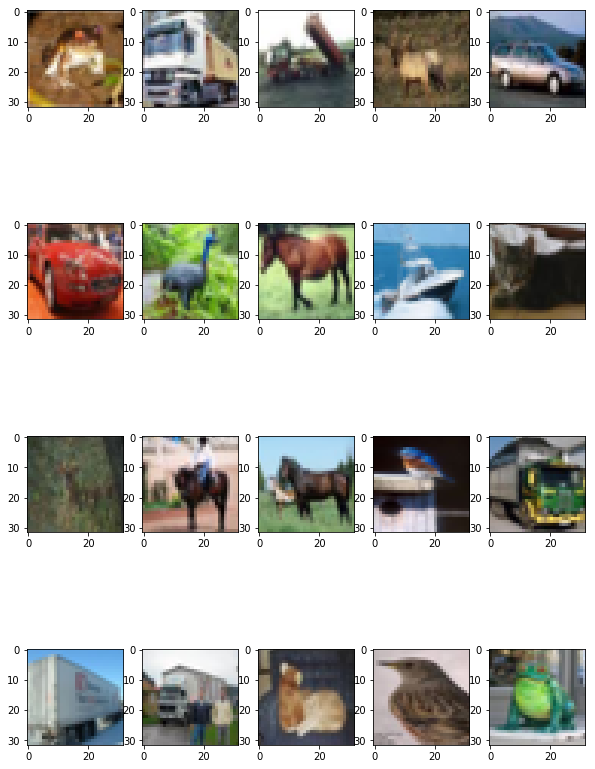

In [26]:
columns = 5
rows = 4
fig=plt.figure(figsize=(10,15))
for i in range(0, columns*rows ):
    #img = np.random.randint(10, size=(h,w))
    img=images[i]
    fig.add_subplot(rows, columns, (i+1))
    plt.imshow(img)
plt.show()

In [27]:
'''
H=np.reshape(samples,(batch_size*num_batches,32,32,3))     
y = images[:50]
y_ = H[:50]

con = tf.confusion_matrix(labels=y_, predictions=y )
sess = tf.Session()
with sess.as_default():
        print(sess.run(con))
'''

'\nH=np.reshape(samples,(batch_size*num_batches,32,32,3))     \ny = images[:50]\ny_ = H[:50]\n\ncon = tf.confusion_matrix(labels=y_, predictions=y )\nsess = tf.Session()\nwith sess.as_default():\n        print(sess.run(con))\n'